In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchaudio.functional as taf
from commpy.filters import rrcosfilter
import torch.nn.functional as F
import torch.optim as optim

from lib.utility import estimate_delay, find_closest_symbol
from lib.channels import AWGNChannel, AWGNChannelWithLinearISI

In [2]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
print(device)

cpu


Epoch 1, Loss: 0.40571863508448625
Epoch 2, Loss: 0.29605686390233804
Epoch 3, Loss: 0.2836683288399246
Epoch 4, Loss: 0.24829102355325947
Epoch 5, Loss: 0.2864289168963558
Epoch 6, Loss: 0.253753452582909
Epoch 7, Loss: 0.28153049404960495
Epoch 8, Loss: 0.2635964812336949
Epoch 9, Loss: 0.29169180718424575
Epoch 10, Loss: 0.2823548016298437
Epoch 11, Loss: 0.30253825610497564
Epoch 12, Loss: 0.2823440477153944
Epoch 13, Loss: 0.3036936176986388
Epoch 14, Loss: 0.2885820088484287
Epoch 15, Loss: 0.28889542794727285
Epoch 16, Loss: 0.28031679306456936
Epoch 17, Loss: 0.2937022007095359
Epoch 18, Loss: 0.26647081127594946
Epoch 19, Loss: 0.29399239092718304
Epoch 20, Loss: 0.28979190906796526
Epoch 21, Loss: 0.2740178035036786
Epoch 22, Loss: 0.28866428602633054
Epoch 23, Loss: 0.2723118155135705
Epoch 24, Loss: 0.3123241394483124
Epoch 25, Loss: 0.29592082124767854
Epoch 26, Loss: 0.25488823056123205
Epoch 27, Loss: 0.292248170964498
Epoch 28, Loss: 0.2702669152316009
Epoch 29, Loss: 0

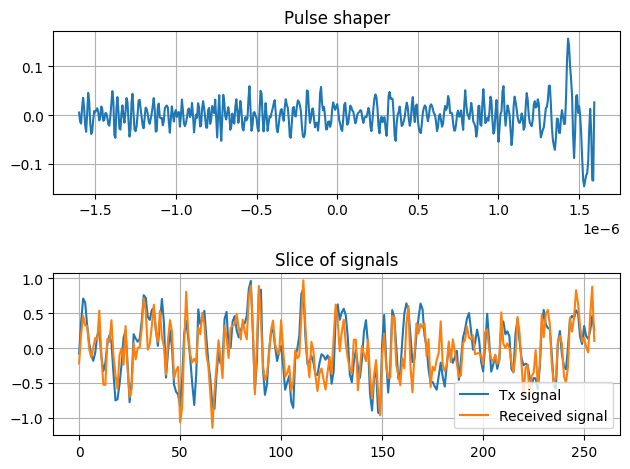

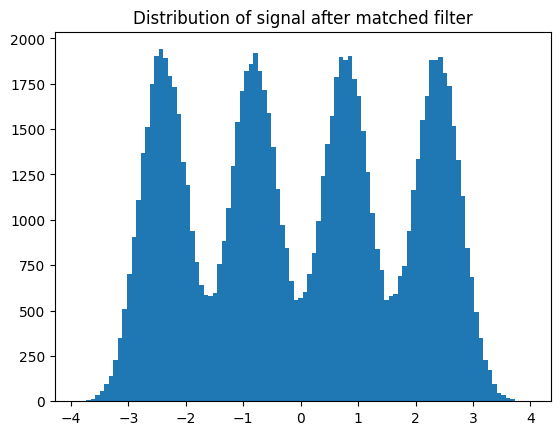

In [3]:
if __name__ == "__main__":
    # Simulation parameters
    # (unchanged parameters here)
    SEED = 12345
    N_SYMBOLS = int(1e5)
    SPS = 16  # samples-per-symbol (oversampling rate)
    SNR_DB = 10.0  # signal-to-noise ratio in dB
    BAUD_RATE = 10e6  # number of symbols transmitted pr. second
    FILTER_LENGTH = 256*2
    Ts = 1 / (BAUD_RATE)  # symbol length
    fs = BAUD_RATE * SPS
    random_obj = np.random.default_rng(SEED)

    # Generate data - use Pulse Amplitude Modulation (PAM)
    pam_symbols = np.array([-3, -1, 1, 3])
    tx_symbols = torch.from_numpy(random_obj.choice(pam_symbols, size=(N_SYMBOLS,), replace=True))

    # Construct pulse shape for both transmitter and receiver
    t, g = rrcosfilter(FILTER_LENGTH, 0.5, Ts, fs)
    g /= np.linalg.norm(g)  # Normalize pulse to have unit energy
    gg = np.convolve(g, g[::-1])
    pulse_energy = np.max(gg)

    # Define the pulse for the transmitter (to be optimized)
    pulse_tx = torch.from_numpy(g).double().requires_grad_(True)
    # pulse_tx =  torch.from_numpy(g).float()

    # Define the pulse for the receiver (fixed)
    pulse_rx = torch.from_numpy(g).double()  # No requires_grad_() as it's not being optimized

    optimizer = torch.optim.Adam([pulse_tx], lr=0.001)
    channel = AWGNChannelWithLinearISI(snr_db=SNR_DB, pulse_energy=pulse_energy, samples_pr_symbol=SPS)
    #####
    num_epochs = 100  # Number of iterations for optimization
    batch_size = 512  # Batch size for optimization
    for epoch in range(num_epochs):
        permutation = torch.randperm(N_SYMBOLS)  
        for i in range(0, N_SYMBOLS, batch_size):
            indices = permutation[i:i+batch_size]
            batch_tx_symbols = tx_symbols[indices]

            optimizer.zero_grad()  # Clear gradients

            # Forward pass (using pulse_tx for transmission)
            tx_symbols_up = torch.zeros((batch_tx_symbols.numel() * SPS, ), dtype=torch.double)
            tx_symbols_up[0::SPS] = batch_tx_symbols.double()
            x = F.conv1d(tx_symbols_up.view(1, 1, -1), pulse_tx.view(1, 1, -1), padding=pulse_tx.shape[0]//2)
            
            # Simulate the channel
            y = channel.forward(x.squeeze())

            # Receiver operations (using pulse_rx for reception)
            rx = F.conv1d(y.view(1, 1, -1), pulse_rx.view(1, 1, -1).flip(dims=[2]), padding=pulse_rx.shape[0]//2).squeeze()

            # Compute loss
            rx_trimmed = rx[:tx_symbols_up.size(0)] 
            loss = F.mse_loss(rx_trimmed, tx_symbols_up)  # Mean squared error loss

            # Backward pass and update
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}, Loss: {loss.item()}")

    #####
    # Calculate some needed statistics on the pulse - used later for synchronization
    gg = np.convolve(g, g[::-1])
    pulse_energy = np.max(gg)
    print(f"Energy of pulse is: {pulse_energy}")
    sync_point = np.argmax(gg)

    # Transmit - up-sample the symbols and apply pulse
    tx_symbols_up = torch.zeros((N_SYMBOLS * SPS, ), dtype=torch.double)
    tx_symbols_up[0::SPS] = tx_symbols
    x = taf.convolve(tx_symbols_up, pulse_tx)  # Apply pulse shaping

    # Apply the "unknown" channel

    
    channel = AWGNChannelWithLinearISI(snr_db=SNR_DB, pulse_energy=pulse_energy, samples_pr_symbol=SPS)
    #channel = AWGNChannel(snr_db=SNR_DB, pulse_energy=pulse_energy)
    y = channel.forward(x)

    # Apply receiver
    rx = taf.convolve(y, torch.flip(pulse_rx, (0,))) / pulse_energy

    # Correct for the pulse-convolutions
    rx = rx[sync_point::]

    # Decision-making - if channel has introduced a delay we need to correct for that
    delay = estimate_delay(rx, sps=SPS)
    print(f"Delay was estimated to be: {delay}")
    symbols_est = rx[delay::SPS]  # pick out every SPS samples to get the symbols
    symbols_est = symbols_est[0:N_SYMBOLS]  # truncate the tail
    symbols_est = find_closest_symbol(symbols_est, torch.from_numpy(pam_symbols))

    # Count symbol errors
    symbol_error_rate = torch.sum(torch.logical_not(torch.eq(symbols_est, tx_symbols))) / len(tx_symbols)
    print(f"SER: {symbol_error_rate:.3e}")

    # FIXME: Implement the EsN0 dB theory.

    x_detached = x.detach().cpu().numpy()
    y_detached = y.detach().cpu().numpy()

    # Plot a subsegment of the transmitted signal and the pulse
    fig, ax = plt.subplots(nrows=2)
    ax[0].plot(t, g)
    ax[0].grid()
    ax[0].set_title('Pulse shaper')

    time_slice = slice(np.argmax(g)-1, np.argmax(g)-1 + 16 * SPS)
    ax[1].plot(x_detached[time_slice], label='Tx signal')
    ax[1].plot(y_detached[time_slice], label='Received signal')
    ax[1].grid()
    ax[1].legend()
    ax[1].set_title('Slice of signals')
    plt.tight_layout()

    # Plot distribution of symbols and plot symbol error rate
    fig, ax = plt.subplots()
    ax.hist(rx.detach().cpu().numpy()[::SPS], bins=100)
    ax.set_title('Distribution of signal after matched filter')

    plt.show()